In [1]:
import sys
import numpy as np

sys.path.append('../..')

from matplotlib import colors as mcolors
from seismicpro.batchflow import Pipeline, Dataset, B, V, F, C
from seismicpro.batchflow.models.torch import UNet
from seismicpro.src import SeismicBatch, FieldIndex, TraceIndex, seismic_plot, CustomIndex, show_research
from seismicpro.batchflow.research import Research, Option

In [2]:
path_raw = '/notebooks/egor/FB/Pal/Pal_Flatiron_1k.sgy'
markup_path = '/notebooks/egor/FB/Pal/Pal_Flatiron_1k_picking.csv'
index = FieldIndex(name='raw', path=path_raw, markup_path=markup_path)

In [3]:
train_index = index.create_subset(index.indices[:40])
train_data = Dataset(TraceIndex((train_index)), SeismicBatch)

In [4]:
test_index = index.create_subset(index.indices[40:50])
test_data = Dataset(TraceIndex((test_index)), SeismicBatch)

In [5]:
inputs_config = {
    'raw': {'shape': (1, F(lambda batch: batch.raw.shape[2]))},
    'mask': {'shape': (1, F(lambda batch: batch.raw.shape[2])),
              'classes': 2,
              'data_format': 'f',
              'name': 'targets'}
    }

config = {
    'inputs': inputs_config,
    'initial_block/inputs': 'raw',
    'optimizer': ('Adam', {'lr': 0.001}),
    'head/num_classes': 2, 
    'body/num_blocks': 5,
    'body/filters': C('filters'),
    'body/encoder': dict(layout='cna cna', kernel_sizee=C('kernel_size')),
    'body/decoder': dict(layout='cna cna', kernel_size=C('kernel_size')),
    'device': C('device'),
}

In [16]:
B_SIZE = 64
train_pipeline = (train_data.p
                      .load(components='raw', fmt='segy')
                      .load(components='markup', fmt='picks')
                      .normalize_traces(src='raw', dst='raw')
                      .picking_to_mask(src='markup', dst='mask')
                      .init_model('dynamic', UNet, 'my_model', config)
                      .init_variable('loss', init_on_each_run=list)
                      .preprocess_model_inputs(src=['raw','mask'], dst=['raw', 'mask'])
                      .train_model('my_model', B('raw'), B('mask'), 
                                   fetches='loss', save_to=V('loss',mode='w'))
                      .run(B_SIZE, n_epochs=None, drop_last=True, shuffle=21, lazy=True))

test_pipeline = (test_data.p
                      .import_model('my_model', C('import_from'))
                      .load(components='raw', fmt='segy')
                      .load(components='markup', fmt='picks')
                      .drop_zero_traces(num_zero=700, src='raw')
                      .normalize_traces(src='raw', dst='raw')
                      .picking_to_mask(src='markup', dst='mask')
                      .add_components(components='unet_predictions')
                      .preprocess_model_inputs(src=['raw','mask'], dst=['raw', 'mask'])
                      .predict_model('my_model', B('raw'),
                                     fetches='predictions',  save_to=B('unet_predictions', mode='a'))
                      .mask_to_pick(src='unet_predictions', dst='unet_predictions', labels=False)
                      .init_variable('picking', init_on_each_run=list())
                      .update_variable('picking', B('mask'), mode='a')
                      .init_variable('predictions', init_on_each_run=list())
                      .update_variable('predictions', B('unet_predictions'), mode='a')
                      .run(1000, n_epochs=1, drop_last=False, shuffle=False, lazy=True))

In [17]:
grid = Option('filters', [[8, 16, 32, 64, 128]]) * Option('kernel_size', [5, 7, 21]) 

In [18]:
def mae(iteration, experiment, pipeline):
    pipeline = experiment[pipeline].pipeline
    pred = np.hstack(np.concatenate(pipeline.get_variable('predictions')))
    true = np.argmax(np.vstack(pipeline.get_variable('picking')), axis=1)
    return np.mean(np.abs(true - pred))

In [19]:
research = (Research()
    .add_pipeline(train_pipeline, dataset=train_data, variables='loss', name='train')
    .add_pipeline(test_pipeline, dataset=test_data, name='test', run=True, execute='%10', import_from='train')
    .add_grid(grid)
    .add_function(mae, returns='mae', name='test_mae', execute='%10', pipeline='test')
)

In [20]:
research.run(n_reps=1, n_iters=1000, workers=3, name='my_research', gpu=[4,5, 6], bar=True, framework='torch')

Research my_research_4 is starting...


  0%|          | 0/3000 [00:00<?, ?it/s]

Distributor has 3 jobs with 1000 iterations. Totally: 3000


100%|██████████| 3000/3000 [12:41<00:00,  3.94it/s]


In [21]:
results = research.load_results(use_alias=True)

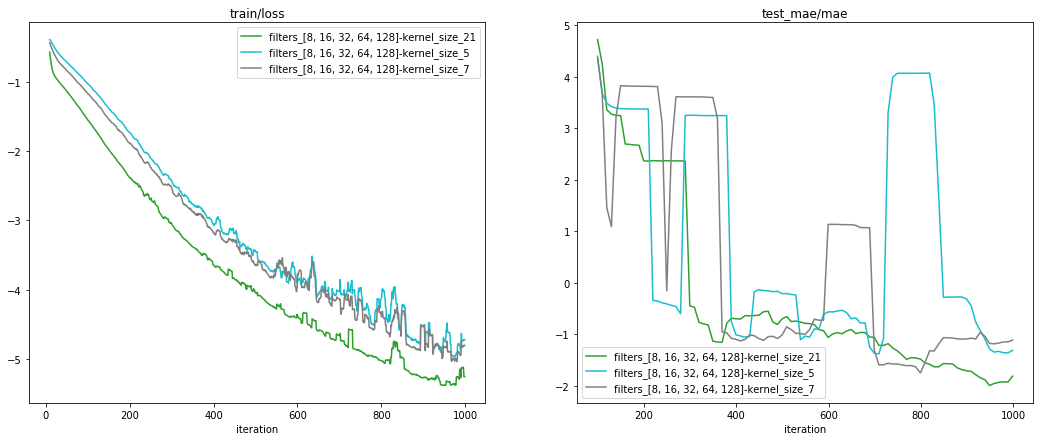

In [29]:
show_research(results, layout=['train/loss', 'test_mae/mae'], average_repetitions=True, color=list(mcolors.TABLEAU_COLORS.keys()), log_scale=True, rolling_window=10)